# Hawaii Climate Analysis

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
import numpy as np
import pandas as pd
import datetime as dt

In [2]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, distinct

In [3]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [4]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [5]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [8]:
from sqlalchemy import inspect
inspector = inspect(engine)
print(inspector.get_columns('Measurement'))
print(inspector.get_columns('Station'))

[{'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}, {'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'date', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'prcp', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'tobs', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}]
[{'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}, {'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'name', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'latitude', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 

In [9]:
from datetime import datetime
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date = datetime.strptime(last_date.date, "%Y-%m-%d")
prev_year =  last_date - dt.timedelta(days=365)
df = pd.read_sql(session.query(Measurement).filter(Measurement.date.between(prev_year, last_date)).\
                 statement, session.bind)
df = df.sort_values(by=['date'])#.dropna()
df = df.set_index('date')
df.head()

,id,station,prcp,tobs
date,,,,
2016-08-24,2365,USC00519397,0.08,79.0
2016-08-24,8826,USC00517948,NaN,78.0
2016-08-24,14609,USC00519281,2.15,77.0
2016-08-24,7332,USC00514830,2.28,80.0
2016-08-24,5092,USC00513117,2.15,76.0


<IPython.core.display.Javascript object>


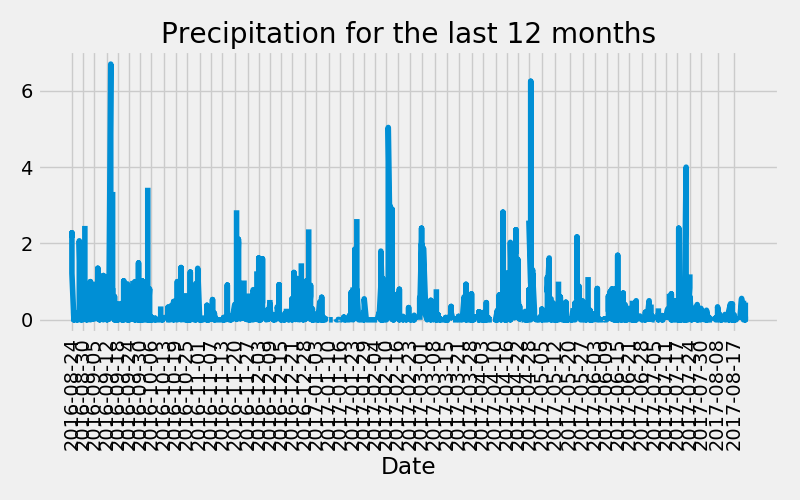

In [10]:
# Use Pandas Plotting with Matplotlib to plot the data
# Rotate the xticks for the dates

fig = plt.figure(figsize = (8,5))
ax = plt.axes()
fig1 = ax.plot(df.index, df['prcp'])
ax.set_xticks(df.index[::40])
ax.set_xticklabels(df.index[::40], rotation=90)
ax.set_title("Precipitation for the last 12 months")
ax.set_xlabel("Date")
plt.tight_layout()
plt.show()

In [53]:
df.prcp.describe()

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

In [11]:
# How many stations are available in this dataset?\n",
station_count = session.query(func.count(distinct(Measurement.station))).all()
station_count

[(9)]

In [12]:
# What are the most active stations?
active_stations = session.query(func.distinct(Measurement.station), func.count(Measurement.station)).\
                group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_stations
# List the stations and the counts in descending order.

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [13]:
#Getting temperature summary for all the stations 
sel = [func.distinct(Measurement.station),
       func.avg(Measurement.tobs), 
       func.min(Measurement.tobs), 
       func.max(Measurement.tobs)]
summary = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(Measurement.station).all()
summary

[('USC00511918', 71.61596766043456, 53.0, 87.0),
 ('USC00513117', 72.68918420081211, 59.0, 85.0),
 ('USC00514830', 74.8732970027248, 58.0, 85.0),
 ('USC00516128', 70.91500765696784, 58.0, 84.0),
 ('USC00517948', 74.68440233236151, 58.0, 87.0),
 ('USC00518838', 72.72407045009784, 58.0, 83.0),
 ('USC00519281', 71.66378066378067, 54.0, 85.0),
 ('USC00519397', 74.55323054331865, 56.0, 87.0),
 ('USC00519523', 74.5436493068565, 56.0, 85.0)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature for MOST ACTIVE STATION
sel = [func.distinct(Measurement.station),
       func.avg(Measurement.tobs), 
       func.min(Measurement.tobs), 
       func.max(Measurement.tobs)]
summary = session.query(*sel).filter(Measurement.station == 'USC00519281').all()
summary

[('USC00519281', 71.66378066378067, 54.0, 85.0)]

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

highest_temp_count = session.query(Measurement.station, func.count(Measurement.tobs)).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.tobs).desc()).limit(1).all()
#Get station 
highest_temp_count[0][0]

'USC00519281'

In [45]:
year_t = session.query(Measurement.tobs).filter(Measurement.date.between(prev_year, last_date)).\
        filter(Measurement.station == 'USC00519281').all()
year_t = np.array(year_t)

<IPython.core.display.Javascript object>


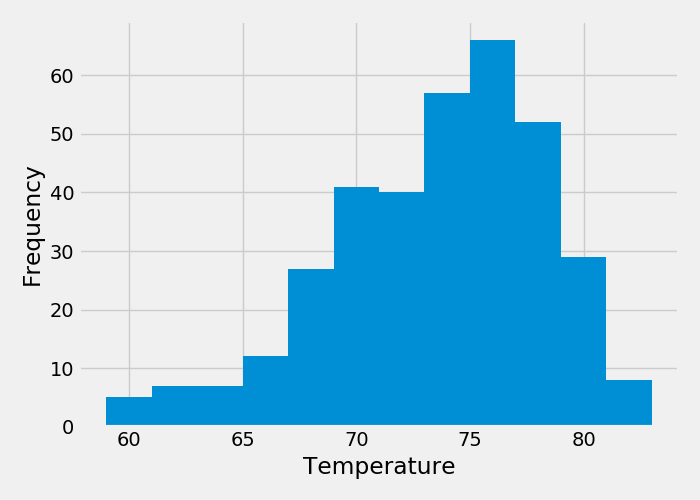

In [46]:
fig = plt.figure(figsize = (7,5))
ax = plt.axes()
fig = ax.hist(year_t, bins=12)
ax.set_ylabel('Frequency')
ax.set_xlabel('Temperature')
plt.tight_layout()
plt.show()

In [48]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates

def calc_temps(start_date, end_date):
    start_date = dt.datetime.strptime(start_date, "%Y-%m-%d")
    end_date = dt.datetime.strptime(end_date, "%Y-%m-%d")
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

start_date =  '2012-07-01'
end_date = '2012-07-15'
print(calc_temps(start_date, end_date))

[(68.0, 74.70873786407768, 82.0)]


In [49]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
summary2017 = calc_temps('2017-07-01', '2017-07-15')

tmin = summary2017[0][0]
tavg = summary2017[0][1]
tmax = summary2017[0][2]
print(tmin, tavg, tmax)

69.0 78.29545454545455 87.0


<IPython.core.display.Javascript object>


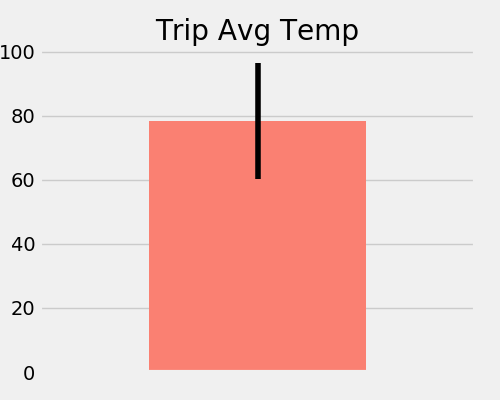

(0.5, 1.5)

In [50]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

width = 0.5       # the width of the bars
fig = plt.figure(figsize = (5,4))
ax = plt.axes()
yerr = tmax - tmin
summary2017 = np.array(summary2017)

ax.bar(x = [1], height=tavg, width = width, color = 'salmon', yerr=yerr)
ax.set_title('Trip Avg Temp')
ax.set_ylabel('Temp(F)')
ax.set_xticks([])
ax.set_xlim(0.5, 1.5)

In [43]:
#Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
# My trip dates are between'2017-07-01', '2017-07-25'
start_date =  '2017-07-01'
end_date = '2017-07-15'
sel = [Measurement.station, Station.name,
       Station.longitude, Station.latitude, Station.elevation, func.sum(Measurement.prcp)]

rainfall_per_station = session.query(*sel).filter(Measurement.station == Station.station).\
                        filter(Measurement.date.between(start_date, end_date)).\
                        group_by(Station.station).\
                        order_by(func.sum(Measurement.prcp).desc()).all()
for record in rainfall_per_station:
    (station, name, long, lat, el, prcp) = record
    print(
        f"The {station} {name} has longitude of {long}, latitude of {lat}, and elevation of {el}." 
        f"It's total precipitation within the given dates is {prcp}.")

The USC00516128 MANOA LYON ARBO 785.2, HI US has longitude of -157.8025, latitude of 21.3331, and elevation of 152.4.It's total precipitation within the given dates is 13.170000000000002.
The USC00519281 WAIHEE 837.5, HI US has longitude of -157.84888999999998, latitude of 21.45167, and elevation of 32.9.It's total precipitation within the given dates is 3.26.
The USC00514830 KUALOA RANCH HEADQUARTERS 886.9, HI US has longitude of -157.8374, latitude of 21.5213, and elevation of 7.0.It's total precipitation within the given dates is 2.26.
The USC00513117 KANEOHE 838.1, HI US has longitude of -157.8015, latitude of 21.4234, and elevation of 14.6.It's total precipitation within the given dates is 1.91.
The USC00519523 WAIMANALO EXPERIMENTAL FARM, HI US has longitude of -157.71139, latitude of 21.33556, and elevation of 19.5.It's total precipitation within the given dates is 0.51.
The USC00519397 WAIKIKI 717.2, HI US has longitude of -157.8168, latitude of 21.2716, and elevation of 3.0.It

In [152]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()


In [219]:
# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings

start_date = "2018-07-01"
start_date = dt.datetime.strptime(start_date, "%Y-%m-%d")
date_list = [start_date + dt.timedelta(days=x) for x in range(0, 15)]
d_truncated = [datetime.strftime(d, '%m-%d') for d in date_list]
d_truncated
 
# # Loop through the list of %m-%d strings and calculate the normals for each date
normals = [daily_normals(d) for d in d_truncated]

from itertools import chain
data = list(chain.from_iterable(normals))

# Load the query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_data = pd.DataFrame.from_records(data, columns = ['tmin', 'tavg', 'tmax'])
trip_data['date'] = pd.Series(date_list)
trip_data = trip_data.set_index('date')
trip_data

,tmin,tavg,tmax
date,,,
2018-07-01,67.0,74.777778,81.0
2018-07-02,68.0,75.403846,82.0
2018-07-03,68.0,75.320755,87.0
2018-07-04,70.0,76.571429,81.0
2018-07-05,66.0,75.000000,81.0
2018-07-06,69.0,75.000000,81.0
2018-07-07,69.0,74.910714,82.0
2018-07-08,69.0,76.083333,83.0
2018-07-09,68.0,76.192982,83.0


<IPython.core.display.Javascript object>


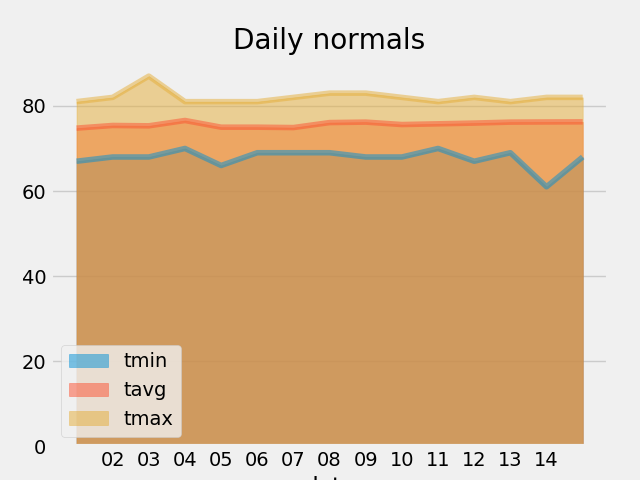

([], <a list of 0 Text xticklabel objects>)

In [225]:
# Plot the daily normals as an area plot with `stacked=False`

trip_data.plot.area(stacked = False)

# fig = plt.figure(figsize = (5,4))
# ax = plt.axes()

# ax.stackplot(trip_data.index, trip_data['tmin'], stacked=False)
plt.title('Daily normals')
# ax.set_ylabel('Temp(F)')
plt.xticks([])

In [ ]:
# Step 2 - Climate App
# Now that you have completed your initial analysis, design a Flask API based on the queries that you have just developed.

# Use FLASK to create your routes.
# Routes
# /api/v1.0/precipitation

# Query for the dates and temperature observations from the last year.

# Convert the query results to a Dictionary using date as the key and tobs as the value.

# Return the JSON representation of your dictionary.

# /api/v1.0/stations

# Return a JSON list of stations from the dataset.
# /api/v1.0/tobs

# Return a JSON list of Temperature Observations (tobs) for the previous year.
# /api/v1.0/<start> and /api/v1.0/<start>/<end>

# Return a JSON list of the minimum temperature, the average temperature, and the max temperature for a given start or start-end range.

# When given the start only, calculate TMIN, TAVG, and TMAX for all dates greater than and equal to the start date.

# When given the start and the end date, calculate the TMIN, TAVG, and TMAX for dates between the start and end date inclusive.
